# Testing Model

In [1]:
from core.networks import La3net

import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
preprocess = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [3]:
dataset = CIFAR10(root="./data", train=False, transform=preprocess, download=True)

Files already downloaded and verified


In [4]:
dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

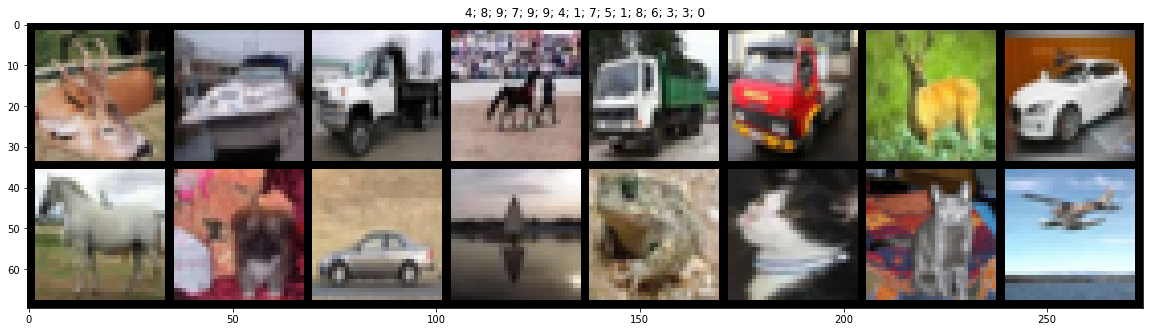

In [7]:
inputs, labels = next(iter(dataloader))
out = torchvision.utils.make_grid(inputs[:16])
plt.rcParams["figure.figsize"] = (20, 10)
imshow(out, title="; ".join([str(label) for label in labels[:16].numpy()]))

In [8]:
model = La3net()
for param in model.parameters():
    param.requires_grad = False

targets, labels = next(iter(dataloader))
target = targets[:1]
label = labels[:1]
target.size()

torch.Size([1, 3, 32, 32])

In [9]:
def find_similar(model, target, number=5, threshold=0.8):
    since = time.time()

    _, c, h, w = target.size()
    top_coefs = torch.zeros(number)
    top_imgs = torch.zeros((number, c, h, w))
    marker = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs, target)
        indices = torch.where(outputs >= threshold)[0]
        
        for indice in indices:
            print("INDICE :", indice)
            if marker<number:
                top_coefs[marker] = outputs[indice]
                top_imgs[marker, :, :, :] = inputs[indice]
                marker += 1
            else:
                break
        
        if marker>=number:
            break
    
    print(f"Search duration: {time.time() - since}s.")
    return top_imgs, top_coefs

In [10]:
top_imgs, top_coefs = find_similar(model, target)

INDICE : tensor(14)
INDICE : tensor(26)
INDICE : tensor(52)
INDICE : tensor(26)
Search duration: 85.37869906425476s.


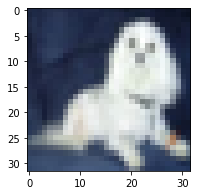

In [11]:
plt.rcParams["figure.figsize"] = (3, 3)
imshow(target[0])

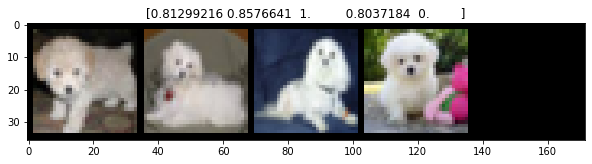

In [12]:
out = torchvision.utils.make_grid(top_imgs)
plt.rcParams["figure.figsize"] = (10, 10)
imshow(out, title=top_coefs.numpy())